## Imports

In [ ]:
import h5py

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from skimage.exposure import match_histograms
from sklearn.decomposition import PCA

import os

import pandas as pd

## Extract and Load Dataset

In [2]:
data_path = '../Data/metastatic-tissue-classification-patchcamelyon'

print(os.listdir(data_path))

['Labels', 'Metadata', 'camelyonpatch_level_2_split_train_mask', 'pcam']


In [3]:
pcam_path = data_path + '/pcam'
pcam_training_file = os.path.join(pcam_path, "training_split.h5")
pcam_validation_file = os.path.join(pcam_path, "validation_split.h5")
pcam_test_file = os.path.join(pcam_path, "test_split.h5")

with h5py.File(pcam_training_file, 'r') as f:
  training_data = f['x'][:]

with h5py.File(pcam_validation_file, 'r') as f:
  val_data = f['x'][:]

with h5py.File(pcam_test_file, 'r') as f:
  test_data = f['x'][:]

In [4]:
# Labels
labels_path = data_path + '/Labels/Labels'
label_training_file = os.path.join(labels_path, "camelyonpatch_level_2_split_train_y.h5")
label_validation_file = os.path.join(labels_path, "camelyonpatch_level_2_split_valid_y.h5")
label_test_file = os.path.join(labels_path, "camelyonpatch_level_2_split_test_y.h5")

with h5py.File(label_training_file, 'r') as f:
  training_labels = f['y'][:]

with h5py.File(label_validation_file, 'r') as f:
  val_labels = f['y'][:]

with h5py.File(label_test_file, 'r') as f:
  test_labels = f['y'][:]

In [5]:
# Metadata
metadata_path = data_path + '/Metadata/Metadata/'

training_metadata = pd.read_csv(metadata_path + 'train_metadata.csv')
val_metadata = pd.read_csv(metadata_path + 'valid_metadata.csv')
test_metadata = pd.read_csv(metadata_path + 'test_metadata.csv')

## Explore Data

In [6]:
print('------------ PCAM -------------')
print('Training data:', training_data.shape)
print('Validation data:', val_data.shape)
print('Test data:', test_data.shape)
print('\n')

print('------------ Labels -------------')
print('Training labels:', training_labels.shape)
print('Benign (Normal) Tissue', np.count_nonzero(training_labels.flatten() == 0))
print('Metastatic Tissue', np.count_nonzero(training_labels.flatten() == 1))
print('Validation labels:', val_labels.shape)
print('Benign (Normal) Tissue', np.count_nonzero(val_labels.flatten() == 0))
print('Metastatic Tissue', np.count_nonzero(val_labels.flatten() == 1))
print('Test labels:', test_labels.shape)
print('Benign (Normal) Tissue', np.count_nonzero(test_labels.flatten() == 0))
print('Metastatic Tissue', np.count_nonzero(test_labels.flatten() == 1))
print('\n')

print('------------ Metadata -------------')
print('Training metadata:', training_metadata.shape)
print('Validation metadata:', val_metadata.shape)
print('Test metadata:', test_metadata.shape)

------------ PCAM -------------
Training data: (262144, 96, 96, 3)
Validation data: (32768, 96, 96, 3)
Test data: (32768, 96, 96, 3)


------------ Labels -------------
Training labels: (262144, 1, 1, 1)
Benign (Normal) Tissue 131072
Metastatic Tissue 131072
Validation labels: (32768, 1, 1, 1)
Benign (Normal) Tissue 16399
Metastatic Tissue 16369
Test labels: (32768, 1, 1, 1)
Benign (Normal) Tissue 16391
Metastatic Tissue 16377


------------ Metadata -------------
Training metadata: (262144, 6)
Validation metadata: (32768, 6)
Test metadata: (32768, 6)


### Explore PCAM Images

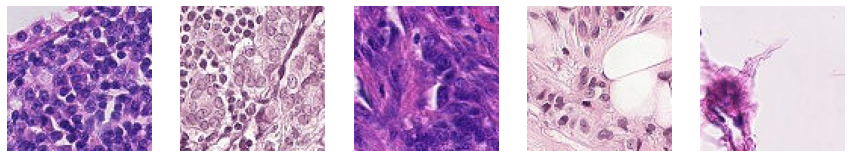

In [7]:
def display_multiple_images(image_array, num_images=5):
    """
    Display multiple images from a NumPy array.

    Parameters:
        image_array (numpy.ndarray): The array of images with shape (N, height, width, channels).
        num_images (int): The number of images to display.
    """
    # Check if num_images is greater than the number of images available
    num_images = min(num_images, image_array.shape[0])

    plt.figure(figsize=(15, 5))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image_array[i].astype('uint8'))  # Convert to uint8 for displaying
        plt.axis('off')

    plt.show()

display_multiple_images(training_data, num_images=5)

Normal Tissue Images

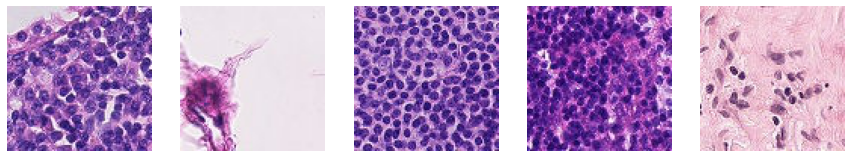

In [8]:
training_data_normal = training_data[training_labels.squeeze() == 0]
display_multiple_images(training_data_normal, num_images=5)

Metastatic Tissue Images

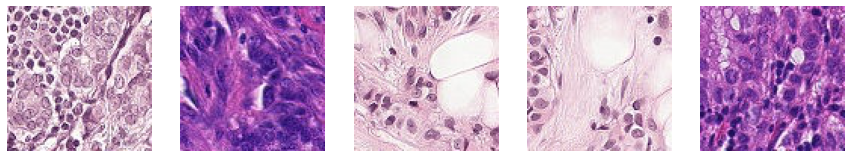

In [9]:
training_data_metastatic = training_data[training_labels.squeeze() == 1]
display_multiple_images(training_data_metastatic, num_images=5)

### Explore Labels

In [10]:
# Get unique labels
unique_labels = np.unique(training_labels)
print("Unique labels:", unique_labels)

# Count occurrences of each label
# Reshape training_labels to a 1D array before using bincount
label_counts = np.bincount(training_labels.reshape(-1))
print("Label counts:", label_counts)

label_counts_val = np.bincount(val_labels.reshape(-1))
print("Label counts val:", label_counts_val)

label_counts_test = np.bincount(test_labels.reshape(-1))
print("Label counts test:", label_counts_test)

Unique labels: [0 1]
Label counts: [131072 131072]
Label counts val: [16399 16369]
Label counts test: [16391 16377]


There is no significant class imbalance. There is approximately equal number of benign and metastatic tissue in the dataset.

### Explore Metadata

In [11]:
training_metadata.head()

,Unnamed: 0,coord_y,coord_x,tumor_patch,center_tumor_patch,wsi
0,0,63104,43648,False,False,camelyon16_train_tumor_104
1,1,148544,74048,True,True,camelyon16_train_tumor_003
2,2,64192,78912,True,True,camelyon16_train_tumor_089
3,3,98048,72128,True,True,camelyon16_train_tumor_004
4,4,27264,50688,False,False,camelyon16_train_normal_118


In [12]:
print("Statistical summary of numerical columns:")
print(training_metadata.describe())

Statistical summary of numerical columns:
          Unnamed: 0        coord_y        coord_x
count  262144.000000  262144.000000  262144.000000
mean   131071.500000   95677.708252   53043.446045
std     75674.598821   50768.330956   26705.645788
min         0.000000       0.000000     128.000000
25%     65535.750000   49920.000000   32896.000000
50%    131071.500000   97728.000000   49152.000000
75%    196607.250000  139328.000000   68736.000000
max    262143.000000  220736.000000  213376.000000


In [13]:
print("Missing values in metadata:")
print(training_metadata.isnull().sum())

Missing values in metadata:
Unnamed: 0            0
coord_y               0
coord_x               0
tumor_patch           0
center_tumor_patch    0
wsi                   0
dtype: int64


## Image Statistics

### Visualize Pixel Value Distributions

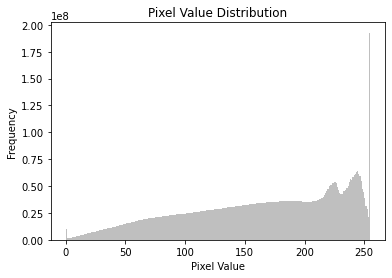

In [14]:
plt.hist(training_data.flatten(), bins=256, color='gray', alpha=0.5)
plt.title('Pixel Value Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

### Stain Density Analysis (Heatmaps for Stain Concentration)

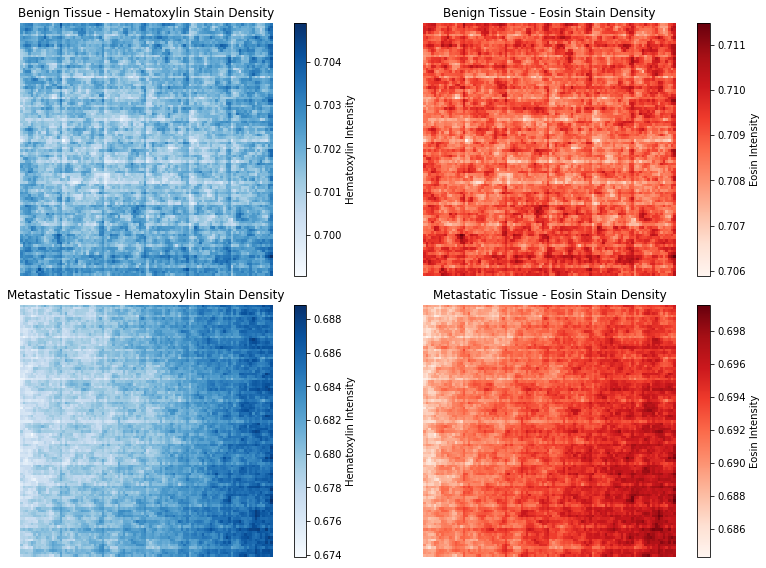

In [15]:
benign_images = training_data[training_labels.squeeze() == 0]  # Filter benign images
metastatic_images = training_data[training_labels.squeeze() == 1]  # Filter metastatic images

# Calculate average Hematoxylin (blue) density for benign and metastatic tissues
average_hematoxylin_benign = np.mean(benign_images[:, :, :, 2] / 255.0, axis=0)
average_hematoxylin_metastatic = np.mean(metastatic_images[:, :, :, 2] / 255.0, axis=0)

# Calculate average Eosin (red) density for benign and metastatic tissues
average_eosin_benign = np.mean(benign_images[:, :, :, 0] / 255.0, axis=0)
average_eosin_metastatic = np.mean(metastatic_images[:, :, :, 0] / 255.0, axis=0)

# Plot the heatmaps
plt.figure(figsize=(12, 8))

# Hematoxylin density heatmap for benign tissue
plt.subplot(2, 2, 1)
plt.imshow(average_hematoxylin_benign, cmap='Blues', interpolation='nearest')
plt.colorbar(label='Hematoxylin Intensity')
plt.title('Benign Tissue - Hematoxylin Stain Density')
plt.axis('off')

# Eosin density heatmap for benign tissue
plt.subplot(2, 2, 2)
plt.imshow(average_eosin_benign, cmap='Reds', interpolation='nearest')
plt.colorbar(label='Eosin Intensity')
plt.title('Benign Tissue - Eosin Stain Density')
plt.axis('off')

# Hematoxylin density heatmap for metastatic tissue
plt.subplot(2, 2, 3)
plt.imshow(average_hematoxylin_metastatic, cmap='Blues', interpolation='nearest')
plt.colorbar(label='Hematoxylin Intensity')
plt.title('Metastatic Tissue - Hematoxylin Stain Density')
plt.axis('off')

# Eosin density heatmap for metastatic tissue
plt.subplot(2, 2, 4)
plt.imshow(average_eosin_metastatic, cmap='Reds', interpolation='nearest')
plt.colorbar(label='Eosin Intensity')
plt.title('Metastatic Tissue - Eosin Stain Density')
plt.axis('off')

plt.tight_layout()
plt.show()

In the **benign tissues**, we see uniform, well-organized cell patterns with both the Hematoxylin Stain and Eosin Stain.

In the **malignant tissues**, there seems to be a gradient where the intensity of hematoxylin and eosin density increases as you go from left to right.